In [2]:
import os
import shutil

BASE_DIR = "/kaggle/input/wound-multitask/Wound Multitask Data Set"
OUTPUT_DIR = "/kaggle/working/dataset"

os.makedirs(f"{OUTPUT_DIR}/Wound", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/No_Wound", exist_ok=True)

# Wound
for img in os.listdir(f"{BASE_DIR}/Wound Images"):
    shutil.copy(
        f"{BASE_DIR}/Wound Images/{img}",
        f"{OUTPUT_DIR}/Wound/{img}"
    )

# No wound
for img in os.listdir(f"{BASE_DIR}/Fresh Images"):
    shutil.copy(
        f"{BASE_DIR}/Fresh Images/{img}",
        f"{OUTPUT_DIR}/No_Wound/{img}"
    )


In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    "/kaggle/working/dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "/kaggle/working/dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    subset="validation"
)


Found 4416 images belonging to 2 classes.
Found 1104 images belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# ⚠️ NE PAS tout geler
for layer in base_model.layers[:-30]:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)


In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 139s 439ms/step - accuracy: 0.9213 - loss: 0.1801 - precision: 0.9288 - recall: 0.9020 - val_accuracy: 1.0000 - val_loss: 0.0011 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 116s 420ms/step - accuracy: 0.9976 - loss: 0.0083 - precision: 0.9963 - recall: 0.9989 - val_accuracy: 1.0000 - val_loss: 3.0109e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 117s 424ms/step - accuracy: 0.9985 - loss: 0.0054 - precision: 0.9980 - recall: 0.9990 - val_accuracy: 1.0000 - val_loss: 1.8764e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 119s 430ms/step - accuracy: 0.9991 - loss: 0.0031 - precision: 0.9995 - recall: 0.9987 - val_accuracy: 1.0000 - val_loss: 1.5472e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 5/15
115/276 ━

KeyboardInterrupt: 

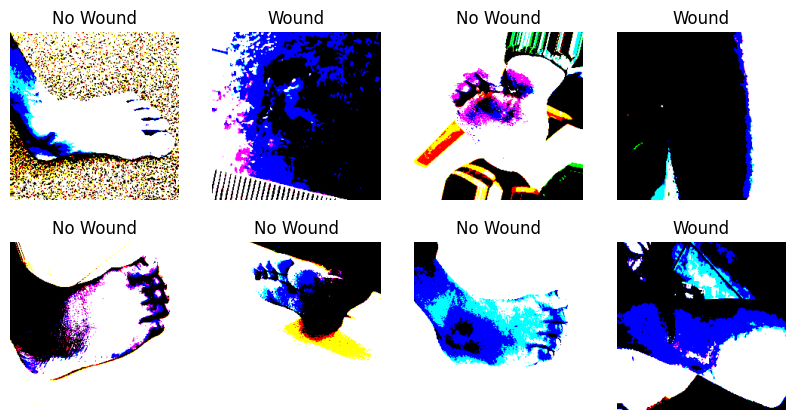

In [18]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_gen)

plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title("Wound" if labels[i]==1 else "No Wound")
    plt.axis("off")
plt.show()


In [23]:
last_conv_layer_name = "conv5_block3_out"

In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [20]:
def load_image(img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img, img_array


In [21]:
def display_gradcam(img, heatmap, alpha=0.4):
    img = np.array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


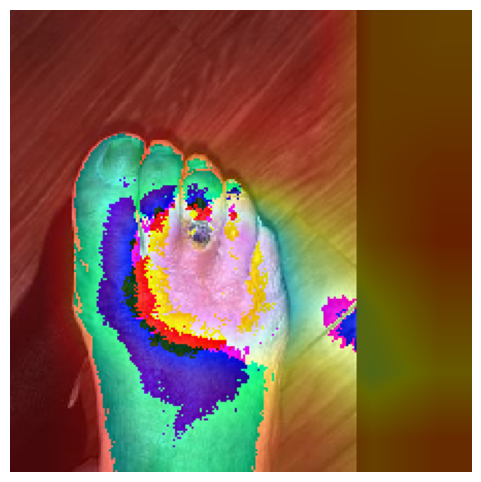

In [27]:
img_path = "/kaggle/input/wound-multitask/Wound Multitask Data Set/Wound Images/fusc_0001.png"

img, img_array = load_image(img_path)
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name
)

display_gradcam(img, heatmap)


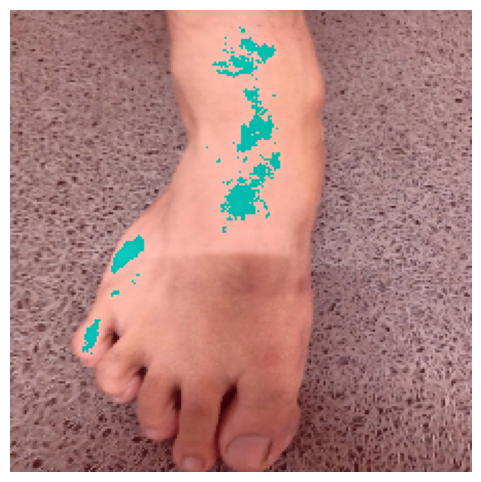

In [26]:
img_path = "/kaggle/input/wound-multitask/Wound Multitask Data Set/Fresh Images/IMG20250820200530.jpg"

img, img_array = load_image(img_path)
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name
)

display_gradcam(img, heatmap)


In [28]:
val_gen.reset()

y_true = val_gen.classes  # vrais labels
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()


69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 318ms/step


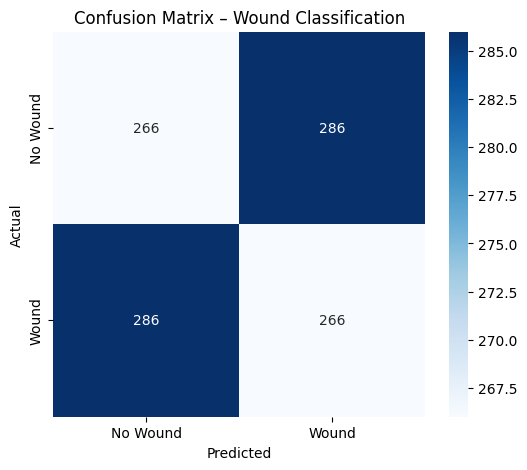

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Wound", "Wound"],
    yticklabels=["No Wound", "Wound"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Wound Classification")
plt.show()


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value": [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]
})

metrics_table


,Metric,Value
0,Accuracy,0.481884
1,Precision,0.481884
2,Recall,0.481884
3,F1-score,0.481884


In [31]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["No Wound", "Wound"]
))


              precision    recall  f1-score   support

    No Wound       0.48      0.48      0.48       552
       Wound       0.48      0.48      0.48       552

    accuracy                           0.48      1104
   macro avg       0.48      0.48      0.48      1104
weighted avg       0.48      0.48      0.48      1104



In [32]:
final_metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision (Wound)": precision_score(y_true, y_pred),
    "Recall (Wound)": recall_score(y_true, y_pred),
    "F1-score (Wound)": f1_score(y_true, y_pred)
}

pd.DataFrame(final_metrics, index=["Score"]).T


,Score
Accuracy,0.481884
Precision (Wound),0.481884
Recall (Wound),0.481884
F1-score (Wound),0.481884
